In [1]:
# Import libraries générales
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist, squareform

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [74]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
dfhi = dfh.reset_index(drop = True)
corpus = dfh.question
len(corpus)

1158

In [4]:
# Titres des lettres
titres = dfh.reset_index(drop = True).titre
questions = dfh.reset_index(drop = True).question
rubriques = dfh.reset_index(drop = True).rubrique

In [5]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [6]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

In [7]:
# DataFrame stockant tous les vecteurs
# VECTORS = pd.DataFrame(columns = ['type','option','vector'])
all_vecs = []

In [8]:
# DataFrame stockant toutes les partitions
# PARTITIONS = pd.DataFrame(columns = ['method','options','culsters'])
all_parts = []

# 1. Vecteurs

## 1.0. TF, TFIDF

In [9]:
# Import for Vectorizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
stop_words = get_stop_words('french')

In [10]:
# Calcul du TF-IF (pour brut, lsa, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_vectors = tfidf.toarray()
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
# VECTORS.loc['tfidf'] = ['tfidf',None,tfidf_vectors]
all_vecs.append(['tfidf',None,tfidf_vectors])

In [11]:
# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_vectors = tf.toarray()
tf_feature_names = np.array(tf_vectorizer.get_feature_names())
# VECTORS.loc['tf'] = ['tf',None,tf_vectors]
all_vecs.append(['tf',None,tf_vectors])

## 1.1 ACP

In [12]:
# Import for PCA
from sklearn.decomposition import PCA

In [13]:
# PCA TF IDF
n_components = 10
pca = PCA(n_components=n_components, random_state=0)
reduced_features_tfidf = pca.fit_transform(tfidf_vectors)
all_vecs.append(['pca_tfidf',n_components,reduced_features_tfidf])

In [14]:
# PCA TF
random_state = 0
dim_pca_tf = 10
pca = pca = PCA(n_components=dim_pca_tf, random_state=0)
reduced_features_tf = pca.fit_transform(tf_vectors)
all_vecs.append(['pca_tf',dim_pca_tf,reduced_features_tf])
# VECTORS.loc['pcatf'] = ['pca_tf',n_components,reduced_features_tf]
# VECTORS.loc['pcatfidf'] = ['pca_tfidf',n_components,reduced_features_tfidf]

## 1.2. LSA

In [15]:
from sklearn.decomposition import TruncatedSVD

In [16]:
dim_lsa = 100 # Pas bon du tout, tenter de voir les meilleures valeurs singulières
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
lsa_doc_vectors = svd_model.fit_transform(tfidf)

In [17]:
lsa_word_vectors = svd_model.fit(tfidf).components_

In [18]:
top10words_lsa = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in lsa_word_vectors])

In [19]:
# VECTORS.loc['lsa10'] = ['lsa',dim_lsa,lsa_doc_vectors]
all_vecs.append(['lsa',dim_lsa,lsa_doc_vectors])

## 1.3. LDA

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
n_topics_lda = 30
lda_doc_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
lda_doc_vectors = lda_doc_model.components_.T

In [22]:
lda_word_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)
lda_word_vectors = lda_word_model.components_

In [23]:
top10words_lda = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in lda_word_vectors])

In [24]:
top10words_lda

array([['maladie', 'projet', 'trouble', 'lyme', 'région', 'dossier',
        'demande', 'prendre', 'vital', 'régime'],
       ['véhicule', 'mer', 'document', 'cœliaqu', 'gris', 'semble',
        'désapprobation', 'carte', 'depp', 'charge'],
       ['diabète', 'em', 'cancer', 'santé', 'maladie', 'autisme', 'an',
        'population', 'mesure', 'quatrième'],
       ['maladie', 'lyme', 'endométriose', 'femme', 'pouvoir',
        'dépistage', 'test', 'france', 'mme', 'gouvernement'],
       ['retraite', 'diplomatique', 'santé', 'chronique', 'manipuler',
        'diabétique', 'test', 'malade', 'pnds', 'lyme'],
       ['maladie', 'diagnostic', 'lyme', 'patient', 'santé', 'protocole',
        'em', 'mme', 'charge', 'prise'],
       ['madagascar', 'myélome', 'livret', 'tarifaire', 'entêter',
        'régularité', 'affection', 'poussiéreux', 'autour', 'avancé'],
       ['demande', 'sécuriser', 'victime', 'usager', 'activité',
        'évolution', 'négociation', '2016', 'délai', 'enseignant'],
 

In [25]:
# VECTORS.loc['lda10'] = ['lda',n_topics_lda,lda_doc_vectors]
all_vecs.append(['lda',n_topics_lda,lda_doc_vectors])

In [26]:
def get_topic_words_lda(centroid):
    """Return top 10 words of the maximum topic of the centroid"""
    return top10words_lda[centroid.argmax()]

def get_dot_words_lda(centroid, head = 20):
    """Return top *head* words corresponding to most caracteristic"""
    centroid_words_lda = np.dot(centroid,lda_word_vectors)
    centroid_words_lda_index = (-centroid_words_lda).argsort()
    return tfidf_feature_names[centroid_words_lda_index][:head]

## 1.4. NMF

In [27]:
from sklearn.decomposition import NMF

In [28]:
n_topics_nmf = 100
nmf_doc_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
nmf_doc_vectors = nmf_doc_model.components_.T

In [29]:
nmf_word_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_word_vectors = nmf_word_model.components_

In [30]:
top10words_nmf = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in nmf_word_vectors])

In [31]:
# VECTORS.loc['nmf10'] = ['nmf',n_topics_nmf,nmf_doc_vectors]
all_vecs.append(['nmf',n_topics_nmf,nmf_doc_vectors])

In [32]:
def get_topic_words_nmf(centroid):
    """Return top 10 words of the maximum topic of the centroid"""
    return top10words_nmf[centroid.argmax()]

def get_dot_words_nmf(centroid, head = 20):
    """Return top *head* words corresponding to most caracteristic"""
    centroid_words_nmf = np.dot(centroid,nmf_word_vectors)
    centroid_words_nmf_index = (-centroid_words_nmf).argsort()
    return tfidf_feature_names[centroid_words_nmf_index][:head]

# 2. Clustering

In [33]:
# Scores de clustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

## 2.1 K-means

In [34]:
from sklearn.cluster import MiniBatchKMeans

In [35]:
# Exécution du k-means
def go_kmeans(vectors, k = 5):
    random_state = 0
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(vectors)
    return kmeans

# Get the clusters of a kmeans
def get_clusters_kmeans(vectors, k=5, kmeans = None):
    if kmeans is None :
        kmeans = go_kmeans(vectors, k)
    return kmeans.predict(vectors)

## 2.2 Hiérarchique

In [36]:
from sklearn.cluster import AgglomerativeClustering

In [37]:
# Get the clusters of a HAC
def get_clusters_HAC(vectors, n_clusters, linkage, affinity):
    aggc = AgglomerativeClustering(linkage=linkage, affinity=affinity, n_clusters=n_clusters)
    aggc = aggc.fit(vectors)
    return aggc.labels_

## 2.3 X-means

In [38]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [39]:
# Get the clusters of a xmeans
def execute_xmeans(vecs,kmin,kmax):
    amount_initial_centers = kmin
    initial_centers = kmeans_plusplus_initializer(vecs, amount_initial_centers).initialize()

    xmeans_instance = xmeans(vecs, initial_centers, kmax)
    xmeans_instance.process()

    groupes = xmeans_instance.get_clusters()
    clusters = pd.Series(
        {j : i for i,m in enumerate(groupes) for j in m}
    ).sort_index().values
    
    return clusters

# 3 Combinaisons

## 3.1 Éxécution de certaines partitions

In [40]:
for i, (name, option, vector) in enumerate(all_vecs) :
    if name != 'tf' and name != 'tfidf':
        for k in [5,10,15]:
            print(name,option,k,'...')
            all_parts.append([name,'kmeans',k,get_clusters_kmeans(vector,k)])
            all_parts.append([name, 'agg average', k,get_clusters_HAC(vector,k,'average','cosine')])
            all_parts.append([name, 'agg complete', k,get_clusters_HAC(vector,k,'complete','cosine')])  
print('fin')

pca_tfidf 10 5 ...
pca_tfidf 10 10 ...
pca_tfidf 10 15 ...
pca_tf 10 5 ...
pca_tf 10 10 ...
pca_tf 10 15 ...
lsa 100 5 ...
lsa 100 10 ...
lsa 100 15 ...
lda 30 5 ...
lda 30 10 ...
lda 30 15 ...
nmf 100 5 ...
nmf 100 10 ...
nmf 100 15 ...
fin


## 3.2 Comparaison des partitions

In [41]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score

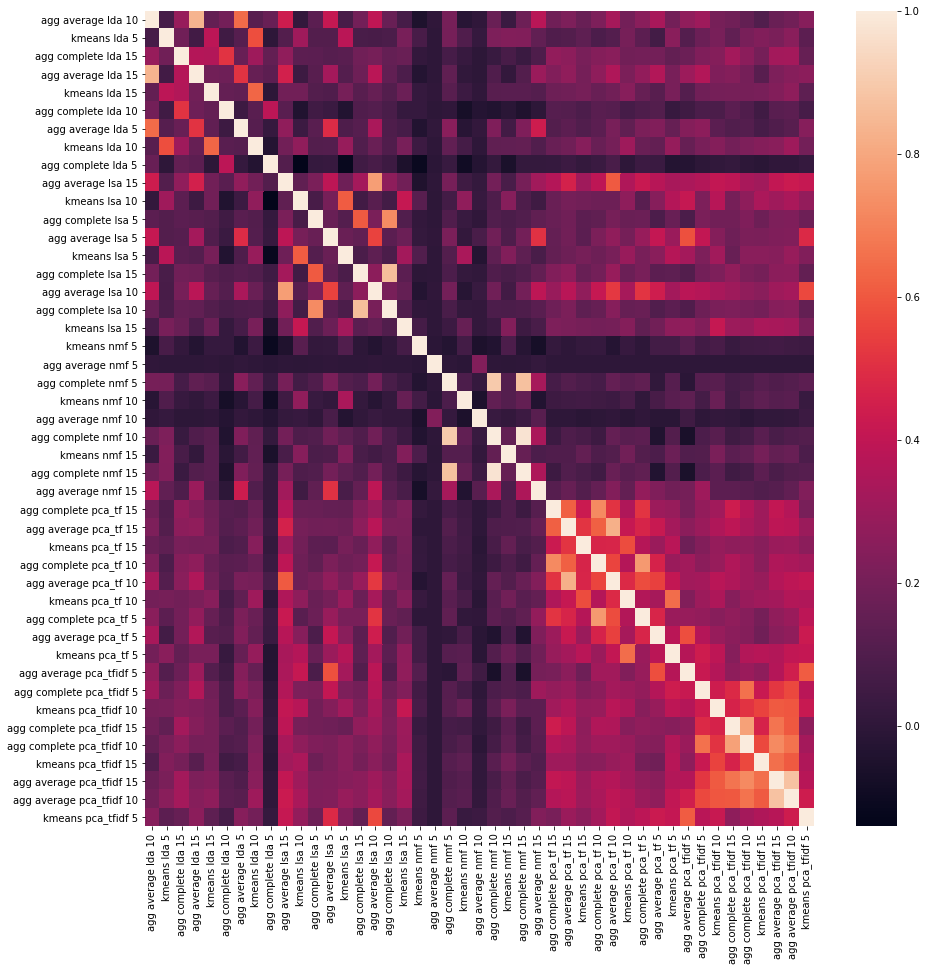

In [42]:
plt.figure(figsize = (15,15))
selection = all_parts
pt = pd.DataFrame(selection,columns = ['vec','method','opt','clusters']).sort_values(by = 'vec')
partitions = np.array([i for i in pt.clusters])
matrix_ARI = pairwise_distances(partitions,metric = adjusted_rand_score)
sns.heatmap(matrix_ARI, xticklabels=pt.method+' '+pt.vec+' ' +pt.opt.apply(str), yticklabels=pt.method+' '+pt.vec+' '+pt.opt.apply(str));

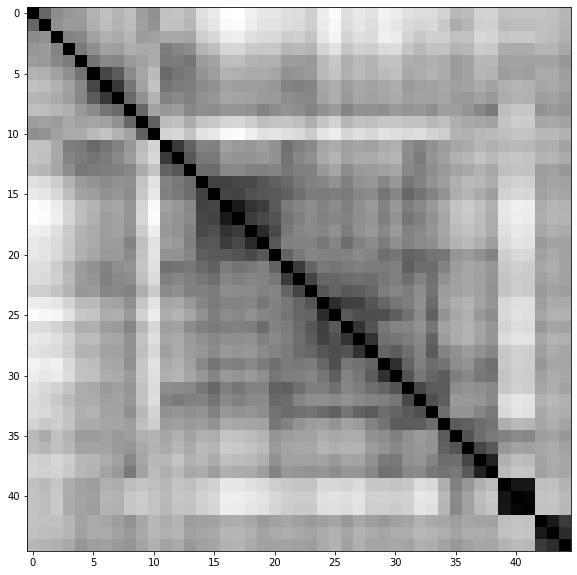

In [43]:
from pyclustertend import vat
vat(matrix_ARI)

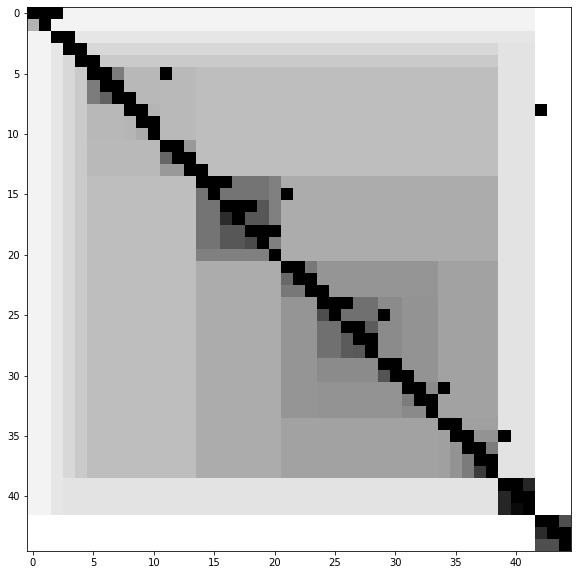

In [44]:
from pyclustertend import ivat
ivat(matrix_ARI)

In [45]:
# Tentative avortée de labelliser
# matrix_ARI = [[0,2,3],[2,0,4],[3,3,0]]
# ordered = pyclustertend.visual_assessment_of_tendency.compute_ordered_dissimilarity_matrix(matrix_ARI)
# for num, line in enumerate(matrix_ARI) :
#     for num_ordre,line_ordre in enumerate(ordered) :
#         if (line == line_ordre).all() :
#             print(num,'->',num_ordre)
# ordered

## 3.3 Combiner les partitions

In [46]:
# import Cluster_Ensembles as CE
# cluster_runs = np.random.randint(0, 50, (50, 15000))
# consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, verbose = True, N_clusters_max = 50)
# consensus_clustering_labels
# Problème de versions : reduce dans functools pour Python3 mais pas Python2

In [47]:
# https://naeglelab.github.io/OpenEnsembles/Examples/Ensemble_Distances_Algorithms_No_Structure.html
# import openensembles as oe

In [48]:
# df = pd.DataFrame(partitions).T
# nbl, dims = df.shape

In [49]:
# dataObj = oe.data(df,range(dims))
# Problème : la bibliothèque utilise les mêmes données avec des méthodes de clustering différentes, 
# tandis que nous avons besoin de données différentes

In [52]:
# Choix du nombre d'objets
nb_obj = 100
objets = partitions.T[:nb_obj]

### 3.3.1 CO

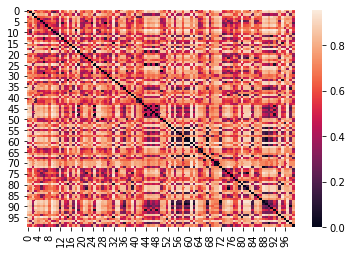

In [53]:
# Matrix
co_matrix = pairwise_distances(objets,metric = lambda x,y : 1- sum(x==y)/len(x))
sns.heatmap(co_matrix);

In [54]:
# CAH
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
%time Z = linkage(objets,metric= lambda x,y : 1- sum(x==y)/len(x),method = 'complete');

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 515 ms


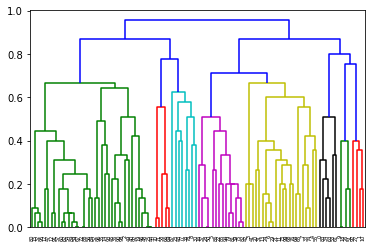

In [55]:
dendrogram(Z);

### 3.3.2 Normalized mutual information

In [56]:
from sklearn.metrics.cluster import normalized_mutual_info_score

CPU times: user 6.08 s, sys: 0 ns, total: 6.08 s
Wall time: 6.08 s


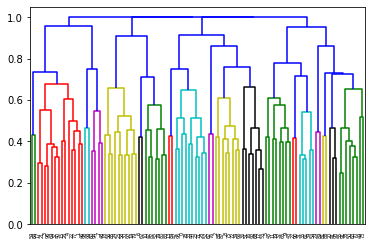

In [57]:
%time Z = linkage(objets,metric= normalized_mutual_info_score, method = 'complete');
dendrogram(Z);

# 4. Étude des clusters

In [58]:
# Choix des vecteurs
doc_vectors = nmf_doc_vectors
top10words = top10words_nmf
word_vectors = nmf_word_vectors

In [59]:
# Choix de l'lagorithme de clustering

# clusters = fcluster(Z, 30, criterion='maxclust')
clusters  = get_clusters_kmeans(doc_vectors, k = 200)
# clusters = execute_xmeans(doc_vectors, 100,200); print(clusters.max())

In [60]:
# Clusters sous forme de dicitonnaire
dc = dict()
for i,c in enumerate(clusters) :
    if c in dc :
        dc[c].append(i)
    else:
        dc[c] = [i]

<BarContainer object of 196 artists>

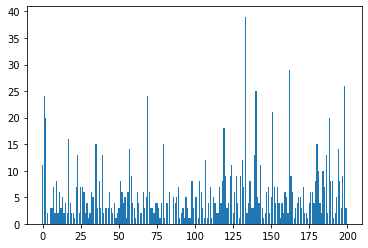

In [61]:
# Octenir la taille des groupes
cc = Counter(clusters)
plt.bar(cc.keys(),cc.values())

0.12145123467377146

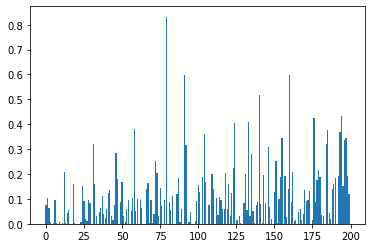

In [62]:
# Obtenir l'inertie des groupes
inerties = {ic:pdist(doc_vectors[dc[ic]],'cosine').mean() for ic in dc if len(dc[ic])>1}
plt.bar(inerties.keys(),inerties.values())
np.array(list(inerties.values())).mean()

In [63]:
# Quelques groupes avec plus de 1 individu
[g for g in cc if cc[g] >1][:15]

[188, 104, 139, 105, 140, 166, 79, 184, 133, 149, 185, 195, 198, 181, 151]

In [64]:
# Pureté
dico_purete = {i:len(rubriques[dc[i]].unique()) for i in dc}
Counter(list(dico_purete.values())),np.mean(list(dico_purete.values()))

(Counter({2: 29, 1: 156, 4: 4, 3: 7}), 1.280612244897959)

In [65]:
# Choisir un numéo de cluster
num_clust = 45
indices = np.array([i for i,t in enumerate(clusters) if t == num_clust])
inertie = pdist(doc_vectors[indices],'cosine').mean()
print('{} individus pour une inertie de {:2f} dans le cluster {} '.format(len(indices),inertie,num_clust))

3 individus pour une inertie de 0.077213 dans le cluster 45 


In [66]:
# Titres des bails
[titres[i] for i in indices]

['difficulté obtenir rendez - préfecture seine-saint-denis',
 'dysfonctionnement site internet préfecture hauts-de-seine',
 'marché noir rendez - préfecture']

In [67]:
# On obtient le centroid correspondants 
centroid = doc_vectors[indices].mean(axis = 0)
# protoype_acp_tfidf = reduced_features_tfidf[indices].mean(axis = 0)

In [68]:
# Les meilleurs topics et leurs mots caractéristiques
{centroid[i] : top10words[i] for i in (-centroid).argsort()[:5]}

{0.4112190335964785: array(['000', 'parfaitement', 'parfois', 'parfum', 'parfumer', 'paris',
        'paritaire', 'parfait', 'parité', 'parkinson'], dtype='<U23'),
 0.07444682984528798: array(['collectivité', 'subvention', 'vis', 'dossier', 'agent',
        'territorial', 'meynier', 'entendue', 'marjolaine', 'millefert'],
       dtype='<U23'),
 0.0358239240531942: array(['ant', 'titre', 'usager', 'site', 'préfecture',
        'dysfonctionnement', 'sécuriser', 'plateforme',
        'dématérialisation', 'ligne'], dtype='<U23'),
 0.0160772846801191: array(['délai', 'dossier', 'traitement', 'demande', 'service', 'mois',
        'délivrance', 'nationalité', 'attente', 'obtention'], dtype='<U23'),
 0.014190986933665125: array(['service', 'public', 'agent', 'trésorerie', 'dgfip', 'usager',
        'finance', 'proximité', 'action', 'suppression'], dtype='<U23')}

In [69]:
# Mots calculés à l'aide du produit
centroid_dot = np.dot(centroid,word_vectors)
centroid_dot_index = (-centroid_dot).argsort()
tfidf_feature_names[centroid_dot_index][:30]

array(['collectivité', 'dossier', 'service', 'subvention', 'délai', 'ant',
       'usager', 'agent', 'titre', 'demande', 'site', 'vis', 'préfecture',
       'dysfonctionnement', 'sécuriser', 'plateforme',
       'dématérialisation', 'démarche', 'intérieur', 'ligne', 'public',
       'agence', 'délivrance', 'internet', 'procédure', 'obtention',
       'français', 'nombreux', 'difficulté', 'territorial'], dtype='<U23')

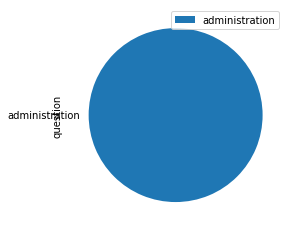

In [70]:
# Les rubriques du clusters
dfh.reset_index(drop = True).loc[indices].groupby('rubrique').count().plot.pie(y='question')

* nmf 100
* kmeans 200
* num 17
* ENA

# Députés correspondants

In [128]:
import networkx as nx

In [196]:
# On sélectionne tous les auteurs contenus dans les lettres
oter = dfhi['ref_auteur']
auteurs = dfhi[['nom_auteur','ref_auteur','groupe_auteur']].groupby('ref_auteur').first()
auteurs['nombre_lettres'] = dfhi.groupby('ref_auteur').count()['question']
oterdic = auteurs.nom_auteur
mat_adj = pd.DataFrame(columns = auteurs.index, index = auteurs.index).fillna(0)

# On ajoute 1 par nombre de lettres envoyées dans le même cluster
G = nx.Graph()
LIMIT_NB_CLUSTERS = 200
for idc in list(dc.keys())[:LIMIT_NB_CLUSTERS] :
    for i,l1 in enumerate(dc[idc]):
        for j,l2 in enumerate(dc[idc][i+1:]):
            a1 = oter[l1]
            a2 = oter[l2]
            G.add_edge(a1, a2)
            try :
                G[a1][a2]['weight']+=1
            except :
                G[a1][a2]['weight']=1

In [183]:
from networkx.drawing.nx_pydot import write_dot

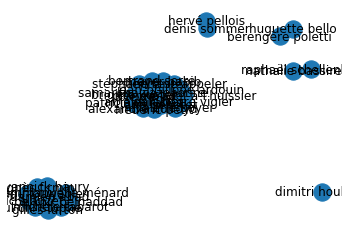

In [197]:
SEUIL = 3
G2 = nx.Graph()
for a1,a2,w in G.edges(data=True):
    if w['weight'] > SEUIL :
        G2.add_edge(oterdic[a1], oterdic[a2])
#             try :
#                 G[a1][a2]['weight']+=1
#             except :
#                 G[a1][a2]['weight']=1
plt.plot(figsize = (20,10))
nx.draw(G2,with_labels=True)
write_dot(G2, 'mieux.dot')

In [198]:
# Créer le graph ps
!dot -Tps mieux.dot -o mieux.ps

In [174]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 20]
pos = nx.spring_layout(G)  # positions for all nodes

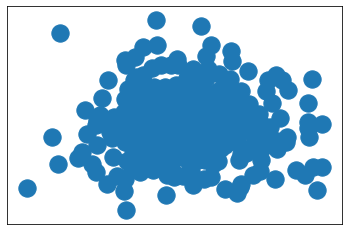

In [175]:
# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge)
# nodes
nx.draw_networkx_nodes(G, pos)

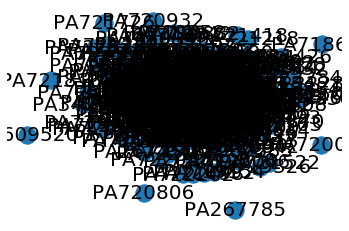

In [171]:
# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()